# Import necessary dependencies and settings

In [0]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 200
%matplotlib inline

In [0]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Sample corpus of text documents

In [45]:
# Import CSV
corpus_df = pd.read_csv("/content/drive/My Drive/DF_selfDialogs.csv")
#corpus_df = pd.read_csv("./data/DF_selfDialogs.csv")
corpus_df = corpus_df[:500]
corpus_df.head(5)

id  \
0  dlg-00055f4e-4a46-48bf-8d99-4e477663eb23   
1  dlg-0009352b-de51-474b-9f13-a2b0b2481546   
2  dlg-00123c7b-15a0-4f21-9002-a2509149ee2d   
3  dlg-0013673c-31c6-4565-8fac-810e173a5c53   
4  dlg-001d8bb1-6f25-4ecd-986a-b7eeb5fa4e19   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Conversation  \
0                                                                                                                                                                                                                                                                                                                                                                                      Hi, I'm looking to book a table for Korean fod. Ok, what area are you thinking about? Somewhere in Southern NYC, maybe the East Village? Ok, great.  There's Thursday Kitchen, it has great reviews. That's great. So I need a table for tonight at 7 pm for 8 people. We don't want to sit at the bar, but anywhere else is fine. They don't have any availability for 7 pm. What times are available? 5 or 8. Yikes, we can't do those times. Ok, do you have a second choice? Let me check. Ok. Lets try Boka, are they free for 8 people at 7? Yes. Great, let's book that. Ok great, are there any other requests? No, that's it, just book. Great, should I use your account you have open with them? Yes please. Great. You will get a confirmation to your phone soon.    
1                                                                                                                                                Hi I would like to see if the Movie What Men Want is playing here. Yes it's showing here would you like to purchase a ticket? Yes, for me and a friend so two tickets please Okay. What time is that moving playing today? That movie is showing at 4, 5, and 8pm. Okay. Is there anymore movies showing around 8pm Yes , showing at 8pm is Green Book. What is that about? It's about two men dealing with racisim. Oh, no can you recommend anything else? What do you like? Well I like movies that are funny. Like comedies? Well no I like action as well. Okay. How to train your dragon is playing at 8pm. Okay can i get two tickets for that ? So you want me to cancel the tickets for What men want ? Yes please. Okay, no problem. How much will this cost. You said two adult tickets? Yes. Okay, that will be $20.80 Okay. Anything else I can help you with ? Yes can i bring my own food to theater. No, sorry you have to purchase food in the lobby. Okay that is fine. Thank you enjoy your movie    
2                                                                                                                                                                                                                                                                                                                                                                               

In [0]:
corpus_df['category'] = corpus_df['Instruction_id'].factorize()[0]

# Simple text pre-processing

In [47]:
from string import punctuation
nltk.download('stopwords')
wpt = nltk.WordPunctTokenizer()

stop_words = nltk.corpus.stopwords.words('english')
remove_terms = punctuation + '0123456789'


#norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]


def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub('[^A-Za-z]+', ' ', doc)
    #doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = remove_terms()
    doc = doc.lower()
    doc = doc.strip()
    #remove_terms = punctuation + '0123456789'
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
for i, row in corpus_df.iterrows():
    corpus_df.at[i, "selfdialog_norm"] = normalize_corpus(row.Conversation) 

In [49]:
doc1 = corpus_df.selfdialog_norm.to_numpy()
#doc_str = np.array2string(doc1, precision=2, separator=' ', suppress_small=True)
doc_str = corpus_df['selfdialog_norm'].to_list()
type(doc_str)

#doc_str

list

In [50]:
corpus = np.array(doc_str)
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['hi looking book table korean fod ok area thinking somewhere southern nyc maybe east village ok great thursday kitchen great reviews great need table tonight pm people want sit bar anywhere else fine availability pm times available yikes times ok second choice let check ok lets try boka free people yes great let book ok great requests book great use account open yes please great get confirmation phone soon',
       'hi would like see movie men want playing yes showing would like purchase ticket yes friend two tickets please okay time moving playing today movie showing pm okay anymore movies showing around pm yes showing pm green book two men dealing racisim oh recommend anything else like well like movies funny like comedies well like action well okay train dragon playing pm okay get two tickets want cancel tickets men want yes please okay problem much cost said two adult tickets yes okay okay anything else help yes bring food theater sorry purchase food lobby okay fine thank en

# Word Embeddings


## Implementing a word2vec model using a CBOW (Continuous Bag of Words) neural network architecture

### Build Vocabulary

In [51]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_corpus)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_corpus]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 3957
Vocabulary Sample: [('like', 1), ('ok', 2), ('would', 3), ('yes', 4), ('order', 5), ('want', 6), ('okay', 7), ('pizza', 8), ('pm', 9), ('thank', 10)]


### Build (context_words, target_word) pair generator


In [0]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [53]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['hi', 'looking', 'table', 'korean'] -> Target (Y): book
Context (X): ['looking', 'book', 'korean', 'fod'] -> Target (Y): table
Context (X): ['book', 'table', 'fod', 'ok'] -> Target (Y): korean
Context (X): ['table', 'korean', 'ok', 'area'] -> Target (Y): fod
Context (X): ['korean', 'fod', 'area', 'thinking'] -> Target (Y): ok
Context (X): ['fod', 'ok', 'thinking', 'somewhere'] -> Target (Y): area
Context (X): ['ok', 'area', 'somewhere', 'southern'] -> Target (Y): thinking
Context (X): ['area', 'thinking', 'southern', 'nyc'] -> Target (Y): somewhere
Context (X): ['thinking', 'somewhere', 'nyc', 'maybe'] -> Target (Y): southern
Context (X): ['somewhere', 'southern', 'maybe', 'east'] -> Target (Y): nyc
Context (X): ['southern', 'nyc', 'east', 'village'] -> Target (Y): maybe


### Build CBOW Deep Network Model


 
We now leverage keras on top of tensorflow to build our deep learning architecture for the CBOW model.
*   For this our inputs will be our context words which are passed to an embedding layer (initialized with random weights).
*   The word embeddings are propagated to a lambda layer where we average out the word embeddings (hence called CBOW because we don’t really consider the order or sequence in the context words when averaged) and then we pass this averaged context embedding to a dense softmax layer which predicts our target word.
*   We match this with the actual target word, compute the loss by leveraging the categorical_crossentropy loss and perform backpropagation with each epoch to update the embedding layer in the process. 

Following code shows us our model architecture.




In [54]:
import keras.backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, Lambda

cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 4, 100)            395700    
_________________________________________________________________
lambda_3 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3957)              399657    
Total params: 795,357
Trainable params: 795,357
Non-trainable params: 0
_________________________________________________________________
None


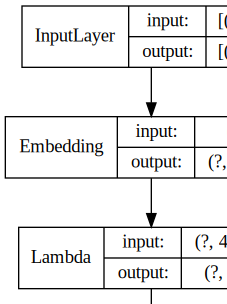

In [55]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, rankdir='TB').create(prog='dot', format='svg'))

### Train model for 5 epochs
Switched it to two epochs for the assignment as the process was very time consuming

In [56]:
for epoch in range(1, 2):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Epoch: 1 	Loss: 355662.04841727763



### Get word embeddings

In [59]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

#pd.DataFrame(weights, index=list(id2word.values())[1:]).head()
pd.DataFrame(weights, index=list(id2word.values())[1:])

(3956, 100)


0     1     2     3     4     5     6     7     8     9     10  \
ok        0.22 -0.04 -0.18 -0.07  0.23  0.05  0.07 -0.09  0.23  0.15  0.25   
would     0.01 -0.20 -0.09 -0.26  0.35  0.04 -0.02 -0.14 -0.03 -0.02  0.22   
yes      -0.10  0.12 -0.28 -0.04  0.38 -0.10 -0.05  0.16 -0.18  0.29 -0.12   
order    -0.17 -0.25 -0.05 -0.29  0.50  0.13 -0.02 -0.15 -0.02 -0.17  0.27   
want     -0.03  0.08 -0.15  0.08  0.33 -0.02 -0.06  0.11 -0.38  0.08  0.20   
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
manage    0.01  0.00 -0.02  0.05 -0.03 -0.00 -0.05  0.02  0.03 -0.03  0.00   
limited   0.00 -0.04  0.05  0.02 -0.01 -0.00 -0.00  0.04  0.01 -0.04  0.06   
mode     -0.04  0.03  0.01 -0.04  0.02  0.05 -0.04 -0.04 -0.03  0.02  0.01   
foraward  0.03  0.02 -0.02 -0.00  0.01  0.03 -0.04  0.02 -0.04  0.05  0.04   
PAD      -0.03  0.03  0.03  0.02 -0.02  0.04  0.03  0.01 -0.02  0.03 -0.02   

            11    12    13    14  ...    85    86    87    88    89    90  \
ok        0.12 -0.08  0.12  0.14  ...  0.08  0.29 -0.05  0.13  0.02  0.10   
would    -0.26  0.15  0.39  0.04  ...  0.35 -0.24 -0.07  0.10  0.20  0.22   
yes      -0.04  0.19  0.22  0.02  ...  0.23  0.08  0.07  0.08  0.15  0.14   
order    -0.42 -0.06  0.31  0.08  ...  0.01 -0.10 -0.07  0.22  0.31  0.19   
want     -0.12  0.06  0.14 -0.08  ... -0.13  0.21 -0.12  0.21  0.18  0.20   
...        ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   
manage    0.01  0.02  0.04 -0.00  ... -0.01 -0.03  0.03  0.06  0.03  0.01   
limited   0.01 -0.01  0.03  0.01  ... -0.02 -0.03  0.05  0.02 -0.02  0.02   
mode     -0.03 -0.02  0.04 -0.03  ...  0.03 -0.04 -0.03  0.03  0.03  0.05   
foraward  0.03  0.02  0.01  0.01  ... -0.04  0.00  0.04 -0.04 -0.02  0.01   
PAD       0.04  0.02 -0.04  0.06  ...  0.01 -0.02 -0.01  0.02 -0.02 -0.04   

            91    92    93    94    95    96    97    98    99  
ok       -0.11 -0.05 -0.00  0.14 -0.03 -0.04 -0.30 -0.01 -0.19  
would    -0.24  0.30 -0.20  0.06  0.03  0.07 -0.16  0.27  0.14  
yes      -0.55  0.11 -0.01 -0.06  0.13  0.19  0.11  0.16  0.17  
order    -0.42  0.19  0.04  0.11  0.14  0.09 -0.01  0.09  0.01  
want     -0.36 -0.09 -0.12  0.28  0.05  0.02  0.05  0.05  0.20  
...        ...   ...   ...   ...   ...   ...   ...   ...   ...  
manage    0.04  0.04 -0.03 -0.03  0.04  0.00  0.01 -0.05  0.04  
limited   0.02 -0.00 -0.03 -0.05  0.01 -0.02  0.05  0.00  0.04  
mode      0.05  0.04 -0.01 -0.03  0.01  0.04 -0.04 -0.01  0.05  
foraward  0.04  0.01 -0.03 -0.01  0.02  0.02  0.00  0.05  0.02  
PAD      -0.01 -0.04  0.02  0.01 -0.02 -0.00 -0.01 -0.03 -0.04  

[3956 rows x 100 columns]

### Build a distance matrix to view the most similar words (contextually)
Had to change the list of similar words as some did not appear because of the reduction in lines from the corpus

In [61]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['ok', 'would', 'yes', 'order', 'want', 'manage', 'limited', 'mode', 'foraward']}

similar_words

(3956, 3956)


{'foraward': ['offers', 'plays', 'stops', 'stacy', 'selective'],
 'limited': ['shops', 'remove', 'mail', 'machiado', 'preheated'],
 'manage': ['crustless', 'alerts', 'carson', 'picky', 'auditorium'],
 'mode': ['greenacres', 'tracy', 'shuts', 'vinegar', 'pastas'],
 'ok': ['okay', 'yes', 'get', 'available', 'time'],
 'order': ['pick', 'drink', 'coffee', 'give', 'type'],
 'want': ['one', 'sure', 'okay', 'please', 'get'],
 'would': ['mind', 'outdoor', 'booked', 'uberxl', 'book'],
 'yes': ['okay', 'ok', 'one', 'please', 'sure']}

## Implementing a word2vec model using a skip-gram neural network architecture


### Build Vocabulary


In [63]:
from tensorflow.python.keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_corpus)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_corpus]

vocab_size = len(word2id) + 1 
embed_size = 100

#wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 3957
Vocabulary Sample: [('like', 1), ('ok', 2), ('would', 3), ('yes', 4), ('order', 5), ('want', 6), ('okay', 7), ('pizza', 8), ('pm', 9), ('thank', 10)]


### Build and View sample skip grams ((word1, word2) -> relevancy)


In [64]:
from tensorflow.python.keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(great (13), foraward (3956)) -> 0
(let (24), point (3705)) -> 0
(nyc (1639), reciept (993)) -> 0
(people (78), worse (1983)) -> 0
(availability (358), eric (3000)) -> 0
(great (13), altamonte (2980)) -> 0
(lets (333), noise (551)) -> 0
(times (130), replacement (2222)) -> 0
(fine (48), russian (3810)) -> 0
(tonight (46), thursday (446)) -> 1


### Build Skip-gram Deep Network Model


In [65]:
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Input, Reshape
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

Inp1 = Input(shape=(1,))
Emb1 = Embedding(vocab_size, embed_size, embeddings_initializer="glorot_uniform", input_length=1)(Inp1)
Resh1 = Reshape((embed_size, ))(Emb1)

Inp2 = Input(shape=(1,))
Emb2 = Embedding(vocab_size, embed_size, embeddings_initializer="glorot_uniform", input_length=1)(Inp2)
Resh2 = Reshape((embed_size, ))(Emb2)

concatenated = concatenate([Resh1, Resh2],axis=1)

out = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(concatenated)

model = Model(inputs=[Inp1, Inp2], outputs=out)
model.compile(loss="mean_squared_error", optimizer="rmsprop")
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 100)       395700      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 100)       395700      input_2[0][0]                    
______________________________________________________________________________________________

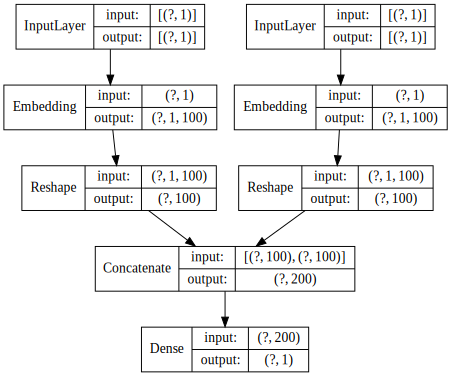

In [66]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, dpi=70, rankdir='TB').create(prog='dot', format='svg'))

### Train the model for 5 epochs
Switched it to two epochs for the assignment as the process was very time consuming

In [67]:
for epoch in range(1, 3):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 75.99485038220882
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 63.7898141592741


### Get word embeddings


In [68]:
weights = model.get_weights()[0][1:]
print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(3956, 100)


0     1    2    3     4     5    6     7     8     9    10    11   12  \
like  0.06 -0.05 0.02 0.01 -0.03 -0.00 0.05 -0.03 -0.03 -0.03 0.02 -0.05 0.05   
ok    0.06 -0.06 0.03 0.05 -0.06 -0.02 0.01 -0.00 -0.01 -0.08 0.02 -0.06 0.07   
would 0.01 -0.06 0.05 0.02 -0.02 -0.01 0.04 -0.04 -0.03 -0.07 0.01 -0.02 0.00   
yes   0.06 -0.05 0.02 0.05 -0.02 -0.04 0.05 -0.05 -0.00 -0.00 0.01 -0.05 0.06   
order 0.03 -0.01 0.02 0.07 -0.07 -0.04 0.05 -0.00 -0.07 -0.04 0.05 -0.01 0.07   

        13   14  ...    85    86   87    88    89    90    91   92   93    94  \
like  0.04 0.07  ... -0.07 -0.01 0.06  0.05 -0.01 -0.01 -0.03 0.07 0.01 -0.03   
ok    0.05 0.05  ... -0.03 -0.03 0.01  0.04 -0.05 -0.03 -0.03 0.00 0.05 -0.01   
would 0.03 0.06  ... -0.02 -0.05 0.01 -0.00 -0.00 -0.07 -0.05 0.04 0.06 -0.05   
yes   0.02 0.02  ... -0.01 -0.01 0.02  0.03  0.00 -0.04 -0.05 0.02 0.04 -0.04   
order 0.05 0.02  ... -0.06 -0.06 0.01  0.02 -0.02 -0.07 -0.01 0.02 0.04 -0.05   

         95   96   97    98    99  
like  -0.07 0.06 0.01 -0.01 -0.04  
ok    -0.06 0.04 0.01 -0.06 -0.01  
would -0.05 0.02 0.04 -0.03 -0.02  
yes   -0.01 0.06 0.05 -0.07 -0.08  
order -0.05 0.06 0.02 -0.01 -0.06  

[5 rows x 100 columns]

### Build a distance matrix to view the most similar words (contextually)


In [70]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['ok', 'would', 'yes', 'order', 'want', 'manage', 'limited', 'mode', 'foraward']}

similar_words

(3956, 3956)


{'foraward': ['pistol', 'nandos', 'preffred', 'oils', 'deserve'],
 'limited': ['shifts', 'cajun', 'expy', 'subaru', 'distance'],
 'manage': ['le', 'balls', 'arive', 'levels', 'grade'],
 'mode': ['issaquah', 'sarah', 'girlfriend', 'vice', 'dress'],
 'ok': ['confirmed', 'type', 'reach', 'way', 'cloud'],
 'order': ['payment', 'sit', 'open', 'peppers', 'excellent'],
 'want': ['showtimes', 'booking', 'honda', 'get', 'together'],
 'would': ['tomatoes', 'almond', 'low', 'together', 'busy'],
 'yes': ['available', 'year', 'tall', 'thinking', 'driving']}

### Visualize word embeddings

In [71]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

IndexError: ignored

## Leveraging gensim for building a word2vec model


In [73]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['ok', 'would', 'yes', 'order', 'want', 'manage', 'limited', 'mode', 'foraward']}
similar_words

{'foraward': ['mode', 'limited', 'manage', 'preffered', 'floor'],
 'limited': ['manage', 'mode', 'foraward', 'preffered', 'ceasers'],
 'manage': ['limited', 'mode', 'foraward', 'preffered', 'indoor'],
 'mode': ['foraward', 'manage', 'limited', 'preffered', 'indoor'],
 'ok': ['meant', 'darn', 'thats', 'hold', 'cads'],
 'order': ['pickup', 'nashville', 'johns', 'pick', 'store'],
 'want': ['yeah', 'single', 'dang', 'sweeter', 'snacks'],
 'would': ['works', 'like', 'type', 'silano', 'specialty'],
 'yes': ['associated', 'discover', 'additional', 'confirm', 'requirements']}

## Visualizing word embeddings

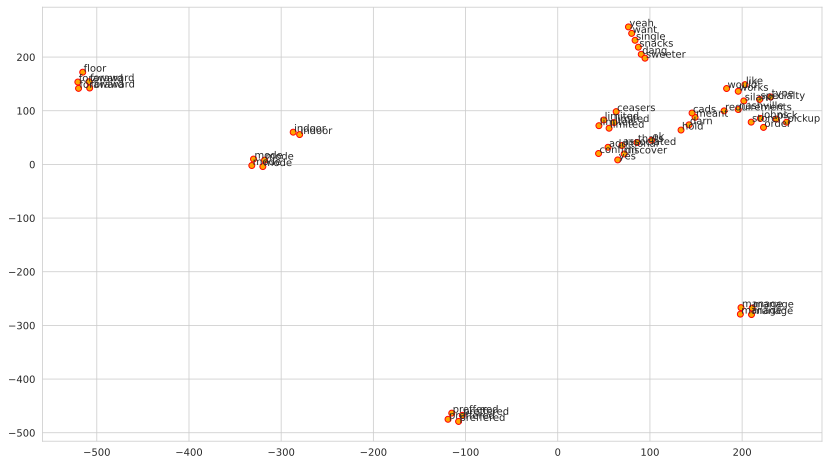

In [74]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Applying the word2vec model on our sample corpus

In [0]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

## Visualize word embeddings

In [76]:
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Sample word embedding

In [77]:
w2v_model.wv['movie']

array([-0.875502 , -2.9372468, -7.714418 , -1.1587013,  5.0498896,
       -7.5510855,  1.0898322,  3.5294704, -3.7607522,  1.876245 ],
      dtype=float32)

## Build framework for getting document level embeddings

In [0]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [79]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

0     1     2     3     4     5     6     7     8     9
0   -0.93 -1.69 -0.97 -0.14  0.44 -0.25  1.13 -0.55  2.25  0.67
1   -0.83 -1.69 -2.43  0.61  1.99 -1.69  0.73 -0.01  0.27 -0.62
2   -1.22 -1.88 -2.06 -0.49  2.67 -2.37  0.45  0.68 -0.44  0.94
3    0.42 -1.75  0.17 -0.08  0.26  0.47 -1.59 -2.10 -0.77 -1.45
4   -0.01 -2.23 -0.17 -1.17  0.46  0.99 -1.31 -2.38 -2.18 -2.31
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
495 -2.44 -1.02 -2.17 -0.40 -2.41  1.00  0.31 -0.56 -0.08  1.29
496 -1.31 -0.76  0.38 -1.10  1.33  0.38 -0.96 -0.11 -0.46  0.59
497 -0.48  0.90  1.18  1.75  1.88  1.75 -2.67 -1.96  1.17 -1.03
498 -0.49 -1.33 -0.76 -1.99  0.60  0.60  1.55 -0.72  3.39  0.03
499 -0.74 -1.56 -1.00 -0.36  0.08  0.07  1.18 -0.99  1.38  1.10

[500 rows x 10 columns]

## Clustering with word embeddings


In [80]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

id  \
0    dlg-00055f4e-4a46-48bf-8d99-4e477663eb23   
1    dlg-0009352b-de51-474b-9f13-a2b0b2481546   
2    dlg-00123c7b-15a0-4f21-9002-a2509149ee2d   
3    dlg-0013673c-31c6-4565-8fac-810e173a5c53   
4    dlg-001d8bb1-6f25-4ecd-986a-b7eeb5fa4e19   
..                                        ...   
495  dlg-107ef34f-f127-4a27-8190-478cd351d08f   
496  dlg-1081b6ca-df03-4edf-807f-bae8f0f5559d   
497  dlg-108ae97c-4cbc-4e5f-aa38-eab30125eaad   
498  dlg-10a543e7-a2b9-4336-b420-fa25b9e07fd3   
499  dlg-10cc78c0-cd1f-4472-a8c4-869c5068ed86   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Conversation  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Hi, I'm looking to book a table for Korean fod. Ok, what area are you thinking about? Somewhere in Southern NYC, maybe the East Village? Ok, great.  There's Thursday Kitchen, it has great reviews. That's great. So I need a table for tonight at 7 pm for 8 people. We don't want to sit at the bar, but anywhere else is fine. They don't have any availability for 7 pm. What times are available? 5 or 8. Yikes, we can't do those times. Ok, do you have a second choice? Let me check. Ok. Lets try Boka, are they free for 8 people at 7? Yes. Great, let's book that. Ok great, are there any other requests? No, that's it, just book. Great, should I use your account you have open with them? Yes please. Great. You will get a confirmation to your phone soon.    
1                                                                                                                                                                                                                                                                                                                           Hi I would like to see if the Movie What Men Want is playing here. Yes it's showing here would you like to purchase a ticket? Yes, for me and a friend so two tickets please Okay. What time is that moving playing today? That movie is showing at 4, 5, and 8pm. Okay. Is there anymore movies showing around 8pm Yes , showing at 8pm is Green Book. What is that about? It's about two men dealing with racisim. Oh, no can you recommend anything else? What do you like? Well I like movies that are funny. Like comedies? Well no I like action a

ERROR! Session/line number was not unique in database. History logging moved to new session 59


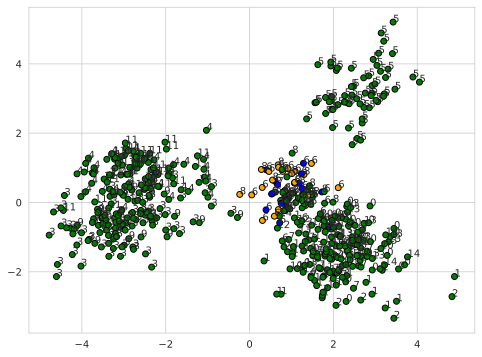

In [89]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

## GloVe Embeddings with spaCy

In [91]:
!python -m spacy download en_core_web_lg
!python -m spacy link /usr/local/lib/python3.6/dist-packages/en_core_web_lg en_vecs
import spacy

nlp = spacy.load('en_vecs')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

     |████████████████████████████████| 827.9MB 2.0MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=29cfe0530f35122ffe7e0440d5a87e74851c0d8484530508de11d70416923746
  Stored in directory: /tmp/pip-ephem-wheel-cache-vnw7ssmy/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en_vecs
You can now load the model via spacy.load('en_vecs')
Total word vectors: 684831


## Visualize GloVe word embeddings

In [92]:
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

0     1     2     3     4     5     6     7     8     9    \
tall         -0.25  0.48 -0.87 -0.12  0.53 -0.23 -0.04  0.33  0.14  1.19   
wich          0.16 -0.15  0.04 -0.51 -0.13 -0.04  0.15 -0.38 -0.01  0.51   
intersection  0.79  0.53  0.07 -0.02  0.70  0.50 -0.29  0.64 -0.25  2.28   
ruby         -0.36 -0.28  0.60  0.14  0.28  0.34  0.26 -0.16  0.02 -0.15   
craving       0.34 -0.13  0.25 -0.09 -0.22  0.32  0.26  0.14  0.30  1.16   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
brake         0.55  0.53  0.19 -0.96 -0.35 -0.01 -0.17 -0.08 -0.83  0.17   
pacakge       0.32 -0.05  0.81 -0.20 -0.03 -0.02  0.38 -0.73 -0.00 -1.46   
anytime       0.13  0.18  0.01  0.15  0.45 -0.24 -0.22 -0.16 -0.04  1.88   
ruth          0.20  0.71  0.35  0.17 -0.03  0.06  0.18  0.18  0.25  0.07   
skis          0.82 -0.25 -0.02 -0.13  0.33  0.41  0.85  0.26 -0.17  0.30   

               10    11    12    13    14   ...   285   286   287   288   289  \
tall          0.43 -0.38 -0.47 -0.01  0.15  ... -0.19 -0.16 -0.01  0.34  0.33   
wich         -0.25 -0.04 -0.22  0.28  0.27  ...  0.14  0.14  0.08  0.02 -0.54   
intersection  0.01  0.19  0.31  0.36 -0.74  ...  0.04 -0.07 -0.18 -0.17 -0.23   
ruby         -0.31 -0.58  0.22 -0.01  0.02  ... -0.97 -0.21  0.32  0.67 -0.70   
craving      -0.37  0.15  0.07 -0.30  0.64  ...  0.22  1.04  0.34 -0.21  0.10   
...            ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   
brake         0.32  0.43 -0.36 -0.02 -0.62  ... -0.54 -0.53 -0.45  0.03 -0.63   
pacakge      -0.38 -0.05 -0.18  0.06  0.88  ...  0.09 -0.28 -0.03  0.08 -0.72   
anytime       0.09  0.11 -0.28 -0.09  0.18  ...  0.14  0.46  0.16 -0.26  0.25   
ruth         -0.50 -0.16  0.01 -0.22 -0.15  ... -0.46  0.19  0.45  0.02 -0.28   
skis          0.49 -0.43  0.07  0.68 -0.29  ... -0.16  0.26 -0.61 -0.08  0.13   

               290   291   292   293   294   295   296   297   298   299  
tall         -0.27 -0.47  0.05 -0.37 -0.38  0.46  0.28  0.01  0.16 -0.59  
wich          0.01 -0.41 -0.44 -0.19  0.31 -0.10  0.20 -0.07  0.15  0.39  
intersection -0.36  0.16  0.19  0.28 -0.28 -0.20  0.02  0.23 -0.14  0.46  
ruby          0.27  0.02 -0.58  0.86  0.31  0.08 -0.19 -0.25 -0.11  0.43  
craving       0.45  0.15 -0.35  0.23  0.06  0.05  0.09 -0.48 -0.28  0.04  
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
brake        -0.64 -0.22  0.47 -0.38  0.10 -0.55  0.50  0.18  0.48 -0.43  
pacakge      -0.04 -0.05  0.34 -0.07 -0.09  0.16 -0.21  0.13  0.26 -0.31  
anytime      -0.11  0.06 -0.16  0.14  0.22 -0.28 -0.31 -0.24  0.04  0.31  
ruth          0.48  0.29  0.01  0.36  0.66 -0.83  0.52 -0.64 -0.23  0.04  
skis         -0.34 -0.63  0.13 -0.71  0.19 -0.12  0.18 -0.22  0.93 -0.56  

[3956 rows x 300 columns]

In [93]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Cluster documents with GloVe Embeddings

In [94]:
from sklearn.cluster import KMeans

doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

id  \
0    dlg-00055f4e-4a46-48bf-8d99-4e477663eb23   
1    dlg-0009352b-de51-474b-9f13-a2b0b2481546   
2    dlg-00123c7b-15a0-4f21-9002-a2509149ee2d   
3    dlg-0013673c-31c6-4565-8fac-810e173a5c53   
4    dlg-001d8bb1-6f25-4ecd-986a-b7eeb5fa4e19   
..                                        ...   
495  dlg-107ef34f-f127-4a27-8190-478cd351d08f   
496  dlg-1081b6ca-df03-4edf-807f-bae8f0f5559d   
497  dlg-108ae97c-4cbc-4e5f-aa38-eab30125eaad   
498  dlg-10a543e7-a2b9-4336-b420-fa25b9e07fd3   
499  dlg-10cc78c0-cd1f-4472-a8c4-869c5068ed86   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Conversation  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Hi, I'm looking to book a table for Korean fod. Ok, what area are you thinking about? Somewhere in Southern NYC, maybe the East Village? Ok, great.  There's Thursday Kitchen, it has great reviews. That's great. So I need a table for tonight at 7 pm for 8 people. We don't want to sit at the bar, but anywhere else is fine. They don't have any availability for 7 pm. What times are available? 5 or 8. Yikes, we can't do those times. Ok, do you have a second choice? Let me check. Ok. Lets try Boka, are they free for 8 people at 7? Yes. Great, let's book that. Ok great, are there any other requests? No, that's it, just book. Great, should I use your account you have open with them? Yes please. Great. You will get a confirmation to your phone soon.    
1                                                                                                                                                                                                                                                                                                                           Hi I would like to see if the Movie What Men Want is playing here. Yes it's showing here would you like to purchase a ticket? Yes, for me and a friend so two tickets please Okay. What time is that moving playing today? That movie is showing at 4, 5, and 8pm. Okay. Is there anymore movies showing around 8pm Yes , showing at 8pm is Green Book. What is that about? It's about two men dealing with racisim. Oh, no can you recommend anything else? What do you like? Well I like movies that are funny. Like comedies? Well no I like action a

# Leveraging gensim for building a FastText model

In [0]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [96]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['ok', 'would', 'yes', 'order', 'want', 'manage', 'limited', 'mode', 'foraward']}
similar_words

{'foraward': ['edwards', 'houston', 'rpx', 'fort', 'friend'],
 'limited': ['submitted', 'order', 'option', 'dropping', 'calories'],
 'manage': ['man', 'package', 'hills', 'showtimes', 'harkins'],
 'mode': ['model', 'appointment', 'intelligent', 'auto', 'solutions'],
 'ok': ['want', 'yes', 'fine', 'need', 'please'],
 'order': ['pick', 'size', 'receipt', 'ready', 'large'],
 'want': ['one', 'like', 'yes', 'would', 'else'],
 'would': ['like', 'please', 'yes', 'want', 'available'],
 'yes': ['please', 'would', 'thank', 'anything', 'like']}

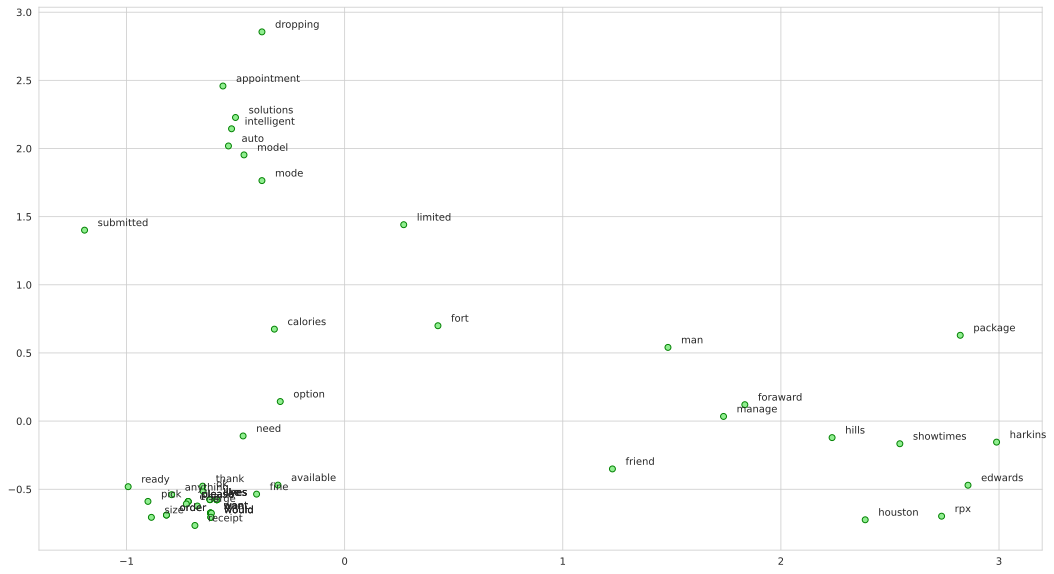

In [97]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [98]:
ft_model.wv['movie']

array([-0.00083625,  0.00246096,  0.33145112, -0.10231514, -0.29731143,
       -0.37049988, -0.04178645,  0.40446606,  0.30658895,  0.27025005,
       -0.64754134, -0.12103311, -0.28538772, -0.4836481 ,  0.3328167 ,
        0.23731272,  0.32243377,  0.08790834,  0.05665041, -0.22724488,
        0.25910866,  0.27128208, -0.11348232,  0.450719  , -0.41978797,
        0.46828267, -0.00777066,  0.03576554,  0.33000687, -0.02117089,
        0.11058964, -0.0664405 ,  0.15518719, -0.5370855 , -0.49047405,
       -0.14135386, -0.05462473, -0.17964754,  0.07110845,  0.05441117,
        0.44726518,  0.6427443 , -0.02734727,  0.00548093, -0.3493585 ,
       -0.24247156,  0.01582453, -0.08604755,  0.1905844 , -0.8783793 ,
        0.1308205 ,  0.2316043 , -0.31061047, -0.3910532 , -0.15000413,
       -0.2804286 ,  0.04212604, -0.23266643,  0.90947574,  0.19481932,
        0.2373951 ,  0.06472538,  0.1623154 ,  0.35833928,  0.5035916 ,
        0.37476996,  0.42750195,  0.09217274, -0.19756022, -0.02

In [99]:
print(ft_model.wv.similarity(w1='movie', w2='restaurant'))
print(ft_model.wv.similarity(w1='movie', w2='pizza'))

0.31358635
0.20204628


In [0]:
# Review Later
#st1 = "god jesus satan john"
#print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

#st2 = "john peter james judas"
#print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ god jesus satan john ]: satan
Odd one out for [ john peter james judas ]: judas
